<a href="https://colab.research.google.com/github/arnaldojr/powerlinesegmentation/blob/main/MESTRADO_Unet_teste1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

import PIL
from PIL import Image
import datetime

import cv2;
import numpy as np; np.random.seed(7);
import os;
import sys;
import tensorflow.keras as keras
import keras.backend as K;
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'


In [ ]:
import tensorflow as tf

print(sys.version)
print("Versao de tensorflow:",tf.__version__)
print("Versao de Keras independente:",keras.__version__)
print("Versao de Keras dentro de tensorflow:",tf.keras.__version__)
print("Versao cv2:",cv2.__version__)
print()

gpu=tf.test.gpu_device_name()
if gpu=="":
  print("Computador sem GPU.")
else:
  print("Computador com GPU:",tf.test.gpu_device_name())
  from tensorflow.python.client import device_lib
  devices=device_lib.list_local_devices()
  print("Dispositivos:",[x.physical_device_desc for x in devices if x.physical_device_desc!=""])
print()

!lsb_release -a | grep "Description" #imprime qual é o sistema operacional
!echo

!cat /proc/cpuinfo | grep -E "model name|core" #especificações de CPU
!echo

!cat /proc/meminfo | grep "Mem" #especificações de RAM

3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
Versao de tensorflow: 2.12.0
Versao de Keras independente: 2.12.0
Versao de Keras dentro de tensorflow: 2.12.0
Versao cv2: 4.7.0

Computador com GPU: /device:GPU:0
Dispositivos: ['device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5']

No LSB modules are available.
Description:	Ubuntu 20.04.5 LTS

model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
core id		: 0
cpu cores	: 1
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
core id		: 0
cpu cores	: 1

MemTotal:       13294256 kB
MemFree:         6971768 kB
MemAvailable:   11072232 kB


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
bdDir = "/content/drive/MyDrive/USP/mestrado-unet28-11/"

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
def unet(input_size = (128,128,1)):
  inputs = Input(input_size) #128x128
  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same' )(inputs)
  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same' )(conv2)

  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  #64x64
  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same' )(pool2)
  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same' )(conv3)

  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)  #32x32
  conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same' )(pool3)
  conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same' )(conv4)
  drop4 = Dropout(0.5)(conv4) #32x32

  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)  #16x16

  conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same' )(pool4)
  conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same' )(conv5)
  drop5 = Dropout(0.5)(conv5)   #16x16

  up6 = Conv2D(256, 2, activation = 'relu', padding = 'same'
              )(UpSampling2D(size = (2,2))(drop5)) #32x32
  merge6 = concatenate([drop4,up6], axis = 3)#32x32
  conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same' )(merge6)
  conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same' )(conv6)

  up7 = Conv2D(128, 2, activation = 'relu', padding = 'same'
              )(UpSampling2D(size = (2,2))(conv6)) #64x64
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same' )(merge7)
  conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same' )(conv7)

  up8 = Conv2D(164, 2, activation = 'relu', padding = 'same'
              )(UpSampling2D(size = (2,2))(conv7)) #128x128
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same' )(merge8)
  conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same' )(conv8)

  conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same' )(conv8)

  conv9 = Conv2D(1, 1, activation = 'sigmoid', padding = 'same',
                 bias_initializer=keras.initializers.Constant(value=1.5))(conv8)

  model = Model(inputs = inputs, outputs = conv9)

  model.compile(optimizer =Adam(learning_rate = 1e-3),
                loss = 'mean_squared_error', metrics = ['accuracy'])
  return model


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Cropping2D
from tensorflow.keras.utils import plot_model

def create_model(input_shape):
    inputs = Input(input_shape)

    # Camada de descida
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='valid')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='valid')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='valid')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='valid')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='valid')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='valid')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='valid')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='valid')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='valid')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='valid')(conv5)

    # Camada de subida
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='valid')(conv5)
    crop4 = Cropping2D(cropping=((4,4), (4,4)))(conv4)
    merge6 = tf.concat([up6, crop4], axis=-1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='valid')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='valid')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='valid')(conv6)
    crop3 = Cropping2D(cropping=((16,16), (16,16)))(conv3)
    merge7 = tf.concat([up7, crop3], axis=-1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='valid')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='valid')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='valid')(conv7)
    crop2 = Cropping2D(cropping=((40,40), (40,40)))(conv2)
    merge8 = tf.concat([up8, crop2], axis=-1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='valid')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='valid')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='valid')(conv8)
    crop1 = Cropping2D(cropping=((88,88), (88,88)))(conv1)
    merge9 = tf.concat([up9, crop1], axis=-1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='valid')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='valid')(conv9)

    # Camada de saída
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=inputs, outputs=conv10)

model = create_model((572,572,1))

plot_model(model, to_file='unet.png', show_shapes=True)

model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 572, 572, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_196 (Conv2D)            (None, 570, 570, 64  640         ['input_18[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_197 (Conv2D)            (None, 568, 568, 64  36928       ['conv2d_196[0][0]']             
                                )                                                           

In [ ]:

#### adaptada
from tensorflow.keras.utils import plot_model

input_img = Input((128, 128, 1), name='img')

model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)


plot_model(model, to_file='unet-adaptada.png', show_shapes=True)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 128, 128, 16  64         ['conv2d_20[0][0]']              
 ormalization)                  )                                                           

In [ ]:
nomeprog="model-mestrado-unet-28-11"
train_path='/content/drive/MyDrive/USP/mestrado-unet-28-11/train';
outDir = "/content/drive/MyDrive/USP/mestrado-unet-28-11/unet_segmentation_out"; os.chdir(outDir)

In [ ]:
aug_dict = dict(rotation_range=10, #Int. Degree range for random rotations.
  width_shift_range=0.05, #float: fraction of total width, if < 1, or pixels if >= 1.
  height_shift_range=0.05, #float: fraction of total height, if < 1, or pixels if >= 1.
  shear_range=10, #Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
  zoom_range=0.2, #Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
  horizontal_flip=False, #Boolean. Randomly flip inputs horizontally.
  fill_mode='reflect'); #One of {"constant", "nearest", "reflect" or "wrap"}.

image_folder='image';
mask_folder= 'label';
target_size = (128,128);
batch_size=32;
seed = 7;
save_to_dir = None;

image_datagen = ImageDataGenerator(**aug_dict);
mask_datagen = ImageDataGenerator(**aug_dict);

image_generator = image_datagen.flow_from_directory(
  train_path,
  classes = [image_folder],
  class_mode = None,
  color_mode = "grayscale",
  target_size = target_size,
  batch_size = batch_size,
  seed = seed);

mask_generator = mask_datagen.flow_from_directory(
  train_path,
  classes = [mask_folder],
  class_mode = None,
  color_mode = "grayscale",
  target_size = target_size,
  batch_size = batch_size,
  seed = seed);

def trainGenerator():
  train_generator=zip(image_generator,mask_generator)
  for (img,mask) in train_generator:
    img=img/255
    mask=mask/255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    yield(img,mask)


Found 453 images belonging to 1 classes.
Found 453 images belonging to 1 classes.


In [ ]:
im_width = 128
im_height = 128
border = 5

input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
from keras.utils import plot_model
#<<<<<<<<<<<<<<<<< main <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
#comecar treino do zero
model = unet()
#model = load_model(nomeprog+".h5");

plot_model(model, to_file='unet-28-11.png', show_shapes=True)

model.summary()

#history=model.fit(trainGenerator(),steps_per_epoch=30,epochs=10,verbose=1);

#history=model.fit(x_train,
#          y_train,
#          batch_size=30,
#          epochs=100,
#          verbose=2,
#          validation_data=(x_val, y_val))



#model.save(nomeprog+"2.h5");

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    ModelCheckpoint('mestrado-UNET-28-11.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
#history=model.fit(trainGenerator(),steps_per_epoch=30,epochs=10,verbose=1);
results = model.fit(trainGenerator(), batch_size=32, epochs=5, callbacks=callbacks)

Epoch 1/5
  92371/Unknown - 10733s 116ms/step - loss: 0.0228 - accuracy: 0.9919

In [ ]:
from matplotlib import pyplot as plt
#accuracy = model.evaluate(x_val, y_val)
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
#testa1.py
import cv2;
import numpy as np; np.random.seed(7);
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import sys;
import tensorflow.keras as keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def leUmDir(imagePath):
  #Le imagens em um diretorio e retorna como float32 entre 0 e +1
  #Tambem retorna os nomes das imagens
  imageList = [f for f in os.listdir(imagePath) if os.path.isfile(os.path.join(imagePath, f))];
  imageList.sort();
  n=len(imageList);

  nl,nc = 128,128;
  AX=np.empty((n,nl,nc),dtype='uint8')

  for i in range(n):
    t=cv2.imread(os.path.join(imagePath, imageList[i]),0);
    t=cv2.resize(t,(nc,nl),interpolation=cv2.INTER_AREA);
    AX[i,:]=t;

  ax = np.float32(AX)/255.0; #Entre 0 e +1
  ax = ax.reshape(n, nl, nc, 1);
  return ax, imageList, AX;

In [ ]:
test_path='/content/drive/MyDrive/USP/unet_segmentation/test/image';
label_path='/content/drive/MyDrive/USP/unet_segmentation/test/label2';
outDir = "/content/drive/MyDrive/USP/unet_segmentation/unet_segmentation_out"; os.chdir(outDir)

model=load_model("wire_unet2.h5");
ax, imageList, AX = leUmDir(test_path);
ax_label, imageList_label, AX_label = leUmDir(label_path);


In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(ax, ax_label, verbose=1)

1/1 [==============================] - 0s 396ms/step - loss: 0.2637 - accuracy: 0.0000e+00


[0.2637270987033844, 0.0]

In [ ]:
preds_val = model.predict(ax, verbose=1)

1/1 [==============================] - 0s 192ms/step


In [ ]:
#preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
from keras import backend as K
from sklearn.metrics import confusion_matrix
import numpy as np


def iou(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    return intersection/union

a = iou(ax_label, preds_val)
print(a)

tf.Tensor(0.4510558, shape=(), dtype=float32)


In [ ]:
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

res = dice_coef(ax_label, preds_val)
print(res, res/20)

tf.Tensor(0.6216941, shape=(), dtype=float32) tf.Tensor(0.031084705, shape=(), dtype=float32)


In [ ]:
print(len(imageList))

20


In [ ]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val, precision, recall

f1_val, precision, recall = get_f1(ax_label, preds_val)
#jac_value = jaccard_score(mask, pred, labels=labels, average=None, zero_division=0)
print(f1_val)
print(precision)
print(recall)

tf.Tensor(0.016459953, shape=(), dtype=float32)
tf.Tensor(0.008614195, shape=(), dtype=float32)
tf.Tensor(0.18451871, shape=(), dtype=float32)


In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
print(f1_m(ax_label, preds_val))
print(precision_m(ax_label, preds_val))
print(recall_m(ax_label, preds_val))

tf.Tensor(0.016459953, shape=(), dtype=float32)
tf.Tensor(0.008614195, shape=(), dtype=float32)
tf.Tensor(0.18451871, shape=(), dtype=float32)


In [ ]:

def pixel_acc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    return intersection/union

a = iou(ax_label, preds_val)
print(a)

In [ ]:
        batch_size = 12
    epochs = 100
    lr = 1e-4

    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(lr),
        metrics=[
            tf.keras.metrics.MeanIoU(num_classes=2),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.Precision()
        ]
    )

1/1 [==============================] - 0s 18ms/step


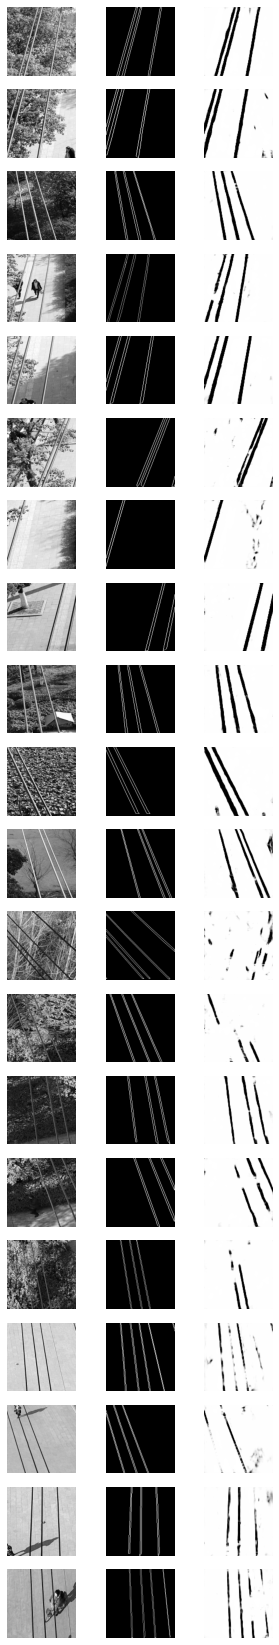

In [ ]:
from matplotlib import pyplot as plt

results = model.predict(ax,verbose=1); #Entre 0 e 1
results = results[:,:,:,0]
results = 255*results
results = np.clip(results,0,255);
qp=results.astype(np.uint8);
j=1
plt.figure(figsize = (5,30))
for i in range(len(imageList)):
  ## entrada
  plt.subplot(20,3,j)
  plt.imshow(AX[i],cmap="gray")
  plt.axis('off')
  j=j+1
  ##label
  plt.subplot(20,3,j)
  plt.imshow(AX_label[i],cmap="gray")
  plt.axis('off')
  j=j+1
  ##predição
  plt.subplot(20,3,j)
  plt.imshow(qp[i],cmap="gray")
  plt.axis('off')
  j=j+1
plt.show()

for i in range(len(imageList)):
  cv2.imwrite(imageList[i],qp[i]);

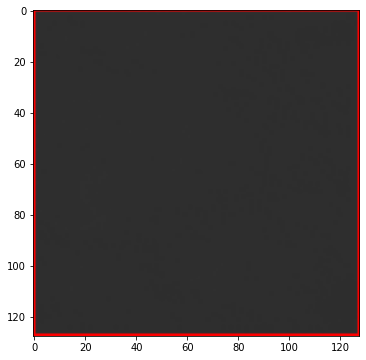

In [ ]:
imgEntrada = AX[0]
imgLabel = AX_label[0]
imgOut = qp[0]
imgOutinv = 255 - imgOut

contornos, _ = cv2.findContours(imgOutinv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
mask_rgb = cv2.cvtColor(imgOutinv, cv2.COLOR_GRAY2RGB)
contornos_img = mask_rgb.copy() # Cópia da máscara para ser desenhada "por cima"

cv2.drawContours(contornos_img, contornos, -1, [255, 0, 0], 1);

plt.figure(figsize=(8,6))
plt.imshow(contornos_img);



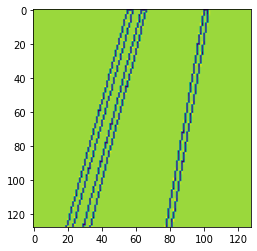

In [ ]:

imgSaida = cv2.bitwise_and(imgLabel, imgOutinv)
imgSaida2 = cv2.bitwise_or(imgLabel, imgOutinv)
imgSaida3 = cv2.bitwise_xor(imgLabel, imgOutinv)

plt.imshow(imgSaida)
plt.show()

In [ ]:
import tensorflow as tf
import keras
print(sys.version)
print("Versao de tensorflow:",tf.__version__)
print("Versao de Keras independente:",keras.__version__)
print("Versao de Keras dentro de tensorflow:",tf.keras.__version__)
print("Versao cv2:",cv2.__version__)
print()

gpu=tf.test.gpu_device_name()
if gpu=="":
  print("Computador sem GPU.")
else:
  print("Computador com GPU:",tf.test.gpu_device_name())
  from tensorflow.python.client import device_lib
  devices=device_lib.list_local_devices()
  print("Dispositivos:",[x.physical_device_desc for x in devices if x.physical_device_desc!=""])
print()

!lsb_release -a | grep "Description" #imprime qual é o sistema operacional
!echo

!cat /proc/cpuinfo | grep -E "model name|core" #especificações de CPU
!echo

!cat /proc/meminfo | grep "Mem" #especificações de RAM

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
Versao de tensorflow: 2.3.0
Versao de Keras independente: 2.4.3
Versao de Keras dentro de tensorflow: 2.4.0
Versao cv2: 4.1.2

Computador com GPU: /device:GPU:0
Dispositivos: ['device: XLA_CPU device', 'device: XLA_GPU device', 'device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5']

No LSB modules are available.
Description:	Ubuntu 18.04.5 LTS

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
core id		: 0
cpu cores	: 1
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
core id		: 0
cpu cores	: 1

MemTotal:       13333580 kB
MemFree:         6192280 kB
MemAvailable:   10517456 kB


In [ ]:
#######################################################################################################3

### visualização intermediaria

#####################################################################################################3333

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                      

In [ ]:
layer_names = [layer.name for layer in model.layers]
layer_names

['input_1',
 'conv2d',
 'conv2d_1',
 'max_pooling2d',
 'conv2d_2',
 'conv2d_3',
 'max_pooling2d_1',
 'conv2d_4',
 'conv2d_5',
 'dropout',
 'max_pooling2d_2',
 'conv2d_6',
 'conv2d_7',
 'dropout_1',
 'up_sampling2d',
 'conv2d_8',
 'concatenate',
 'conv2d_9',
 'conv2d_10',
 'up_sampling2d_1',
 'conv2d_11',
 'concatenate_1',
 'conv2d_12',
 'conv2d_13',
 'up_sampling2d_2',
 'conv2d_14',
 'concatenate_2',
 'conv2d_15',
 'conv2d_16',
 'conv2d_17',
 'conv2d_18']

In [ ]:
model.layers

In [ ]:
layer_outputs = [layer.output for layer in model.layers]
layer_outputs

[<KerasTensor: shape=(None, 128, 128, 1) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'conv2d_3')>,
 <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'conv2d_4')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'conv2d_5')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'dropout')>,
 <KerasTensor: shape=(None, 16, 16, 256) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None,

In [ ]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i , layer.name , layer.output.shape)

1 conv2d (None, 128, 128, 64)
2 conv2d_1 (None, 128, 128, 64)
4 conv2d_2 (None, 64, 64, 128)
5 conv2d_3 (None, 64, 64, 128)
7 conv2d_4 (None, 32, 32, 256)
8 conv2d_5 (None, 32, 32, 256)
11 conv2d_6 (None, 16, 16, 512)
12 conv2d_7 (None, 16, 16, 512)
15 conv2d_8 (None, 32, 32, 256)
17 conv2d_9 (None, 32, 32, 256)
18 conv2d_10 (None, 32, 32, 256)
20 conv2d_11 (None, 64, 64, 128)
22 conv2d_12 (None, 64, 64, 128)
23 conv2d_13 (None, 64, 64, 128)
25 conv2d_14 (None, 128, 128, 164)
27 conv2d_15 (None, 128, 128, 64)
28 conv2d_16 (None, 128, 128, 64)
29 conv2d_17 (None, 128, 128, 2)
30 conv2d_18 (None, 128, 128, 1)


In [ ]:
model = Model(inputs=model.inputs , outputs=model.layers[1].output)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
import cv2
image = load_img("/content/drive/MyDrive/USP/unet_segmentation/test/image/574.jpg" ,grayscale=True, target_size=(128,128))
# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)
#image=cv2.resize(image,(128,128),interpolation=cv2.INTER_AREA);
image.shape

/usr/local/lib/python3.7/dist-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


(1, 128, 128, 1)

1/1 [==============================] - 0s 14ms/step


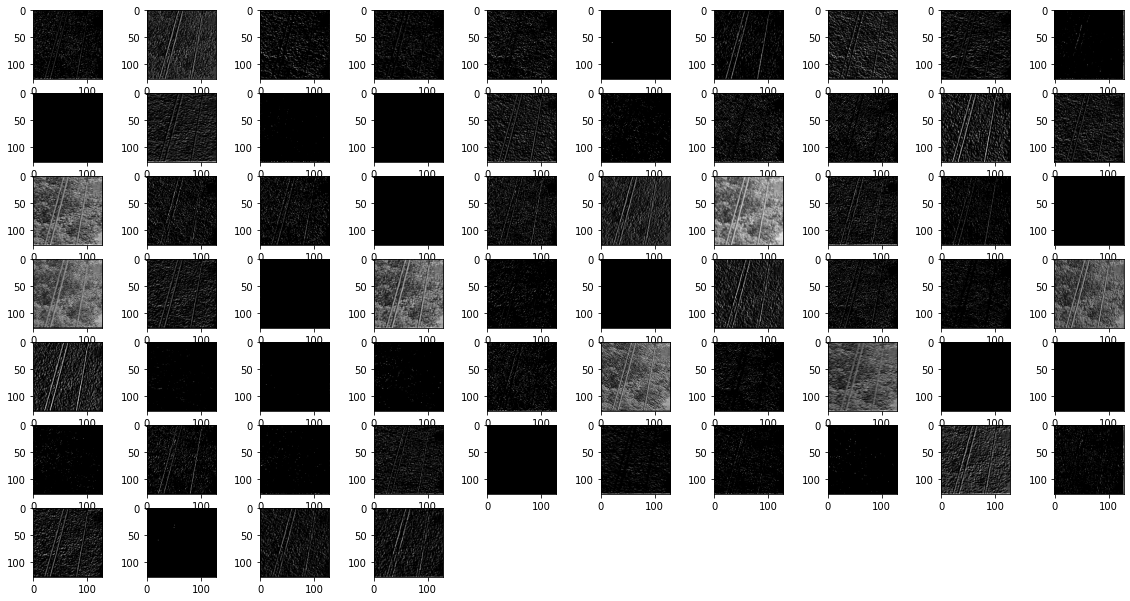

In [ ]:
#calculating features_map
features = model.predict(image)

fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    plt.subplot(10,10,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')

plt.show()